In [1]:
%matplotlib inline

In [2]:
import os
import pymysql
import pandas as pd
import numpy as np

import matplotlib as plt
from ipywidgets import interact, Dropdown, IntSlider, SelectionRangeSlider, Layout, fixed, SelectMultiple
import ipywidgets as widgets
from IPython.display import display

ImportError: cannot import name 'SelectionRangeSlider'

# Imports

In [3]:
infilepath = os.path.join('inputs', 'M1_detectors_Luton-to-MK.csv')
detectors_xy = pd.read_csv(infilepath, index_col=0)

In [4]:
sql_detectors = tuple(detectors_xy.index.values)
#sql_detectors = tuple(['M1/2655A', 'M1/2662A', 'M1/2658A', 'M1/2665A'])

In [5]:
sql_detectors

('M1/2736A',
 'M1/2733A',
 'M1/2733B',
 'M1/2731K',
 'M1/2730A',
 'M1/2731L',
 'M1/2730B',
 'M1/2725J',
 'M1/2725A',
 'M1/2726M',
 'M1/2726B',
 'M1/2717J',
 'M1/2714A',
 'M1/2648A',
 'M1/2651A',
 'M1/2647B',
 'M1/2655A',
 'M1/2655B',
 'M1/2651B',
 'M1/2717A',
 'M1/2718B',
 'M1/2721M',
 'M1/2721B',
 'M1/2721J',
 'M1/2721A',
 'M1/2658B',
 'M1/2637A',
 'M1/2640A',
 'M1/2640B',
 'M1/2637B',
 'M1/2662A',
 'M1/2665A',
 'M1/2665B',
 'M1/2662B',
 'M1/2658A',
 'M1/2676A',
 'M1/2677B',
 'M1/2681A',
 'M1/2685A',
 'M1/2685B',
 'M1/2681B',
 'M1/2688A',
 'M1/2691A',
 'M1/2691B',
 'M1/2688B',
 'M1/2695A',
 'M1/2672A',
 'M1/2674B',
 'M1/2669B',
 'M1/2669A',
 'M1/2710A',
 'M1/2713B',
 'M1/2710B',
 'M1/2704A',
 'M1/2707A',
 'M1/2707B',
 'M1/2704B',
 'M1/2697A',
 'M1/2701A',
 'M1/2700B',
 'M1/2697B',
 'M1/2737B',
 'M1/2643A',
 'M1/2643B',
 'M1/2626M',
 'M1/2606M',
 'M1/2605B',
 'M1/2620A',
 'M1/2595A',
 'M1/2592A',
 'M1/2624J',
 'M1/2599A',
 'M1/2631L',
 'M1/2607B',
 'M1/2595B',
 'M1/2623B',
 'M1/2611A',

In [5]:
conn = pymysql.connect(host='TSCDSSQL01',
                       user='haris',
                       passwd='LihuvGPW4jgbEQ0AyVta!',
                       db='MAIA')
cur = conn.cursor()

# Read the db and convert it to df
sql = 'SELECT * from M1_2015 WHERE `Geographic Address` IN {}'.format(sql_detectors)
sql = "SELECT * from midas_Co30_all_2015 WHERE Geographic_Address IN ('A11/0024B')"

df_raw = pd.read_sql(sql, conn)

# Close the connection
cur.close()
conn.close()

In [6]:
df_raw.head(2)

,Geographic_Address,CO_Address,LCC_Address,Transponder_Address,Device_Address,Datetime,Number_of_Lanes,Flow_Category_1,Flow_Category_2,Flow_Category_3,...,Occupancy_Lane_5,Occupancy_Lane_6,Occupancy_Lane_7,Headway_Lane_1,Headway_Lane_2,Headway_Lane_3,Headway_Lane_4,Headway_Lane_5,Headway_Lane_6,Headway_Lane_7
0,M1/2587B,36,7,141,211,2015-01-01 00:00:00,4,2,0,0,...,-1,-1,-1,0,-1,-1,0,-1,-1,-1
1,M1/2587B,36,7,141,211,2015-01-01 00:01:00,4,5,1,0,...,-1,-1,-1,0,227,140,0,-1,-1,-1


# Cleaning

In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 50)

In [9]:
df = df_raw.copy()

In [10]:
# Replace -1 with NaN, will be used to drop NaN columns
df.replace(-1, np.nan, inplace=True)
df.dropna(1, 'all', inplace=True)
cols_to_drop = ['CO_Address', 'LCC_Address', 'Transponder_Address', 'Device_Address', 'Number_of_Lanes']
df.drop(cols_to_drop, axis=1, inplace=True)
df.rename(columns={'Geographic_Address': 'GA'}, inplace=True)

In [13]:
df.head(2)

,GA,Datetime,Flow_Category_1,Flow_Category_2,Flow_Category_3,Flow_Category_4,Speed_Lane_1,Speed_Lane_2,Flow_Lane_1,Flow_Lane_2,Occupancy_Lane_1,Occupancy_Lane_2,Headway_Lane_1,Headway_Lane_2
0,A11/0024B,2015-01-01 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,A11/0024B,2015-01-01 00:01:00,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Create a dictionary with the variable combinations
categories = dict()

for c in df:
    if '_' in c:
        var, cat, num = c.split('_', 2)
        key = '{}-{}'.format(cat, var)
        
        if key in categories:
            categories[key].append(num)
        else:
            categories[key] = list(num)


In [20]:
d_results = dict()

id_vars = ['GA', 'Datetime']

for k in categories:
    cat, var = k.split('-')
    for c in df:
        if (cat in c) and (var in c):
            value_vars = list()
            for n in categories[k]:
                col_name = '{}_{}_{}'.format(var, cat, n)
                value_vars.append(col_name)
                
    cols_tmp = [*id_vars, *value_vars]
    dft = df[cols_tmp]
    melt = pd.melt(df, id_vars=id_vars, value_vars=value_vars , var_name=cat, value_name=var)
    melt[cat].replace(regex=True, to_replace=r'\D', value=r'', inplace=True)
    melt[cat] = melt[cat].astype('int')
    melt.set_index(list(melt.columns[:-1]), inplace=True)
        
    # Dictionary with all the results
    d_results.setdefault(cat, {})[var] = melt
    

In [21]:
data = {}
for k1 in d_results:
    dfs = []
    for k2, v in d_results[k1].items():
        dfs.append(v)
    df = pd.concat(dfs, axis=1)
    #df = df.swaplevel(0, 1)
    df.sort_index(inplace=True)
    data[k1] = df

# Analysis

In [22]:
idxslc = pd.IndexSlice

In [23]:
df = data['Lane']

In [24]:
df.head(2)

Speed  Flow  Occupancy  Headway
GA        Datetime   Lane                                 
A11/0024B 2015-01-01 1       NaN   0.0        0.0      0.0
                     2       NaN   0.0        0.0      0.0

In [25]:
df_lanes_avg = df.groupby(level=[0,1]).mean()

In [26]:
interv = '15Min'

In [27]:
df_resamped = df_lanes_avg.reset_index(level=0).groupby('GA').resample(interv).mean()

In [28]:
df = df_resamped.copy()

In [29]:
dg = dict(zip(df.index.get_level_values('Datetime'), df.index.get_level_values('Datetime').time))

In [30]:
avg_profiles = df.groupby([None, dg], level=[0,1]).mean()

In [34]:
avg_profiles.describe()

,Speed,Flow,Occupancy,Headway
count,96.000000,96.000000,96.000000,96.000000
mean,104.075413,6.417010,3.007187,66.557645
std,3.030847,4.224314,1.880711,25.750687
min,96.709856,0.579374,0.383609,11.896294
25%,103.176742,1.808032,0.932881,59.613922
50%,104.887293,7.835370,3.524454,68.506767
75%,106.058421,10.019382,4.500508,80.650280
max,108.106846,13.344833,6.120937,108.787717


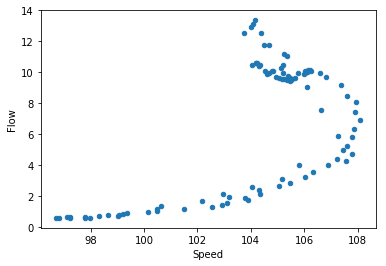

In [37]:
avg_profiles.plot.scatter(0, 1)

In [391]:
dft = df_resamped.loc[idxslc['M1/2655A', '2015-04-13'], :]
dft.reset_index(level=0).groupby('GA').resample('10Min').mean()

dg = dict(zip(df.index.get_level_values('Datetime'), df.index.get_level_values('Datetime').time))
dftg = dft.groupby([None, dg], level=[0,1]).mean()
dftg

Speed    Flow  Occupancy    Headway
GA       Datetime                                          
M1/2655A 00:00:00   93.100000   3.625      1.825  64.566667
         00:10:00   96.650000   3.425      1.775  69.141667
         00:20:00  115.250000   3.600      1.625  67.708333
         00:30:00  113.833333   4.400      1.775  62.925000
         00:40:00  110.966667   3.500      1.775  57.508333
         00:50:00  111.500000   3.575      2.050  69.916667
         01:00:00  114.941667   3.700      1.725  71.908333
         01:10:00  111.150000   3.825      1.925  71.133333
         01:20:00  111.558333   3.025      1.650  68.091667
         01:30:00  109.533333   3.200      1.975  74.208333
         01:40:00  108.900000   1.750      0.750  63.641667
         01:50:00  108.366667   2.150      1.425  49.366667
         02:00:00  106.450000   2.125      1.475  58.175000
         02:10:00  105.466667   2.350      1.550  73.150000
         02:20:00  101.966667   2.050      1.375  55.183333
         02:30:00  110.283333   1.725      0.950  61.075000
         02:40:00  104.650000   1.350      1.050  39.016667
         02:50:00  103.583333   1.475      0.975  63.233333
         03:00:00  107.050000   1.500      0.875  49.433333
         03:10:00  101.900000   1.350      0.800  59.841667
         03:20:00  106.166667   1.675      1.100  69.166667
         03:30:00  103.483333   1.425      0.975  47.850000
         03:40:00  104.983333   2.275      1.425  63.758333
         03:50:00  106.166667   1.975      1.350  81.475000
         04:00:00  105.100000   2.275      1.425  59.733333
         04:10:00  109.483333   2.400      1.675  60.383333
         04:20:00  104.583333   2.775      1.825  68.075000
         04:30:00  109.650000   2.550      1.600  58.641667
         04:40:00  108.666667   2.850      1.725  68.116667
         04:50:00  111.200000   3.025      1.825  69.050000
...                       ...     ...        ...        ...
         19:00:00   99.350000  12.225      6.000  62.025000
         19:10:00   98.375000  12.450      5.975  58.041667
         19:20:00  100.650000  11.675      5.675  58.525000
         19:30:00  100.625000  11.900      6.300  55.975000
         19:40:00  100.825000  11.075      5.750  64.325000
         19:50:00  100.108333  10.725      5.600  51.108333
         20:00:00  102.933333  10.600      5.550  36.400000
         20:10:00  108.666667  10.400      5.125  37.425000
         20:20:00  107.466667  10.050      5.225  36.575000
         20:30:00  105.316667   9.650      5.200  41.800000
         20:40:00  106.866667   8.800      4.625  40.800000
         20:50:00  105.716667   8.525      4.775  39.458333
         21:00:00  106.358333   8.625      4.800  45.233333
         21:10:00  107.200000   8.450      4.775  47.675000
         21:20:00  106.475000   7.450      4.675  48.641667
         21:30:00  107.866667   7.450      4.150  53.200000
         21:40:00  109.333333   6.725      3.800  60.700000
         21:50:00  109.166667   7.150      3.650  55.475000
         22:00:00  109.600000   5.700      3.475  53.950000
         22:10:00  110.200000   5.700      3.000  63.200000
         22:20:00  108.733333   5.875      3.075  63.083333
         22:30:00  112.033333   5.175      2.600  61.075000
         22:40:00  111.416667   5.100      2.450  57.616667
         22:50:00  111.700000   5.400      2.875  70.825000
         23:00:00  109.950000   5.075      2.925  54.083333
         23:10:00  111.183333   4.050      2.175  61.866667
         23:20:00  108.316667   4.000      2.375  65.225000
         23:30:00  111.383333   3.300      1.750  69.658333
         23:40:00  112.616667   4.100      1.975  63.675000
         23:50:00  107.633333   4.150      2.350  69.425000

[144 rows x 4 columns]

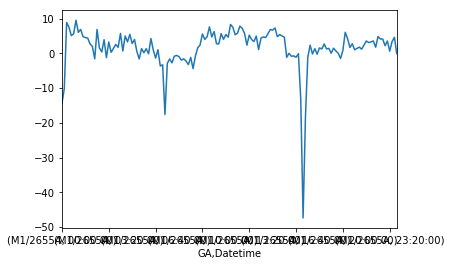

In [395]:
dftg.sub(avg_profiles).dropna().Speed.plot()

In [16]:
def update_plot(data, var, timerange, freq):    
    
    var=list(var)
    df = data[var]
    start_time = timerange[0]
    end_time = timerange[1]
    
    df = df.between_time(timerange[0], timerange[1])

    if freq > 0:
        freq = '{}Min'.format(freq)
        dfg = df.groupby(pd.Grouper(freq=freq)).mean()
        #title = '{} - {}'.format(dfg.name, freq)
        ax = dfg.plot()
        #ax.set_ylabel(data.name)
        return ax
    else:
        print('Frequency cannot be 0')
        

In [17]:
timerange = detector_data.index.strftime('%X')
descr_time = 'Time:{} - {}'.format(timerange[0], timerange[-1])

lyt=Layout(width='30%', height='30px')
style = {'description_width': 'initial'}

interact(update_plot, data=fixed(detector_data), 
         var=SelectMultiple(options=variables, value=[variables[0]], description='Variable:'),
         timerange=SelectionRangeSlider(options=timerange, value=(timerange[0], timerange[-1]), description=descr_time, style=style, layout=lyt),
         freq=IntSlider(min=0, max=180, step=5, value=5, description='Freq:', layout=lyt),
        )


NameError: name 'variables' is not defined

In [18]:
widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False

SyntaxError: unexpected EOF while parsing (<ipython-input-18-88c1ab322c30>, line 6)